# Neural Additive Models 

In [35]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from typing import Tuple
from typing import Dict
from typing import Sequence
from types import SimpleNamespace

import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn import datasets # datasets is a sub-package. https://stackoverflow.com/questions/41467570/sklearn-doesnt-have-attribute-datasets

## NAM


### Feature Neural Net
There is a DNN-based sub net for each feature. To better fit jagged functions, the author proposes *exp-centered* (ExU) hidden units.
#### Activation 
Two different hidden unit (activation) are compared: standard ReLU, and ExU. 

##### ExU
ExU hidden unit use an activation function $f$ to compute $h(x)$ given by 
$$
h(x) =f(e^{\omega}*(x-b))
$$
where $f$ can be any activation function ($\text{ReLU-n}$, ReLU capped at n, is used here), $\omega, b$ are the weight and bias parameters.  

In [2]:
class ReLU_n(nn.Module):
    def __init__(
        self, 
        n: int = 1,
    ) -> None: # type-check
            """
            ReLU capped at n.
            """
            self.n = n
            super(ReLU_n, self).__init__()
            
    def forward(self, x): 
            # self.zeros = torch.zeros_like(x)
            # self.ones = torch.ones_like(x)
            # return torch.min(torch.max(x, self.zeros), self.ones)
            x = F.relu(x)
            return torch.clamp(x, 0, self.n)
            

In [3]:
def test_ReLU_n():
    n_inputs = 5 
    n = 2
    relu_n = ReLU_n(n)
    inputs = torch.randn(n_inputs)
    print(inputs)
    y = relu_n(inputs)
    print(y)
test_ReLU_n()

tensor([ 0.8371, -1.6139, -0.8203, -1.2857, -0.5912])
tensor([0.8371, 0.0000, 0.0000, 0.0000, 0.0000])


In [4]:
class ExU(nn.Module):
    def __init__(
        self, 
        name: str = "ExU",
        in_features: int = 1, 
        out_features: int = 1, # note: output features can be of different dimension to the input features
        ) -> None: # type-check
            """
            an ExU unit, return ReLU_n[exp(w)*(x-b)], where w and b are the weight and bias parameters, 
            and ReLU_n is ReLU function capped at n.
            Args:
            name: identifier for feature net selection
            in_features: scalar, size of each input sample
            out_feature: scalar, size of each output sample

            """
            super(ExU, self).__init__()
            self.in_features = in_features
            self.out_features = out_features
            self.weights = nn.Parameter(torch.Tensor(in_features, out_features))
            self.bias = nn.Parameter(torch.Tensor(in_features)) # note; a bias for each feature
            
            self.initialize_parameters()  
            
    def ReLU_n(self, n, x):
        """
        ReLU capped at n
        """
        x = F.relu(x)
        return torch.clamp(x, 0, n)
    
            # TODO: how about bias? - bias ~ N(0, 0.5^2)
    def initialize_parameters(self):
        """
        Initializing the parameters, specifically:
        - for weights: normal distribution N(x, 0,5²) with x in [3, 4]
        - for bias: N(0, 0.5²)
        
        note that a variance of 0.5 is introduced in the article, but in fact a std of 0.5 is used here
        """     
                # mean = torch.rand(in_features) + torch.ones(in_features)*3
                # std = torch.sqrt(torch.ones(in_features) * 0.5)
                # self.weights = torch.normal(mean=mean, std=std)
                
                # mean = np.random.rand(1) + 3 # a random x in [3, 4]
        mean = 4.0 # note a fixed mean of 4 is used in source codes 
        torch.nn.init.trunc_normal_(self.weights, mean=mean, std=0.5) 
        torch.nn.init.trunc_normal_(self.bias, std=0.5) 
          
            
    def forward(self, 
               inputs: torch.Tensor, 
               n: int = 1
               ) -> torch.Tensor:
        """
        Args:
        inputs of shape (batch_size, in_features)
        
        """
        # note: matrix product!
        exp_cofficient = torch.exp(self.weights)
        # print("exp:", exp_cofficient)
        output = torch.matmul(inputs-self.bias, exp_cofficient)
        
        # print("output:", output)
        # ReLU-n
        # relu_n = ReLU_n(n)
        output = self.ReLU_n(n, output)
        # print("relu: ", output)
        return output

In [5]:
def test_ExU():
    # TODO
    n_inputs = 5 
    n_outputs = 3
    exu = ExU(in_features=n_inputs, out_features=n_outputs)
    inputs = torch.randn(n_inputs)
    print(inputs)
    y = exu(inputs, 1)
    print(y)
test_ExU()

tensor([ 3.2795e-01,  8.5115e-01, -1.3553e+00,  7.2498e-07, -8.9950e-01])
tensor([0., 0., 0.], grad_fn=<ClampBackward1>)


/share/apps/anaconda-ci/fgci-centos7-anaconda/software/anaconda/2023-01/2eea7963/lib/python3.10/site-packages/torch/nn/init.py:176: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


##### Standard ReLU
Standard linear ReLU is used as baseline to ExU, $h(x)$ is given by 
$$
h(x) = f(\omega *(x - b))
$$
where $f(x)$ 
$$
f(x) = \begin{cases} 
0, & x \leq 0, \\
x, & x>0
\end{cases}
$$

In [6]:
class LinearReLU(nn.Module):
    def __init__(
        self, 
        name: str = "LinearReLU",
        in_features: int = 1, 
        out_features: int = 1, # note: output features can be of different dimension to the input features
        ) -> None: # type-check
            """
            Standard linear ReLU hidden unit.
            name: identifier for feature net selection
            in_features: scalar, the size of input sample
            out_feature: scalar, the size of output sample
            """
            super(LinearReLU, self).__init__()
            self.in_features = in_features
            self.out_features = out_features
            self.weights = nn.Parameter(torch.Tensor(in_features, out_features))
            self.bias = nn.Parameter(torch.Tensor(in_features)) # note; a bias for each feature
            
            self.initialize_parameters()  
            
            # TODO: how about bias? - bias ~ N(0, 0.5^2)
    def initialize_parameters(self):
        """
        Initializing the parameters. 
        - weights: regular, xavier uniform(why uniform?)
        - bias: N(0, 0.5²)
        """
        nn.init.xavier_uniform_(self.weights)
        torch.nn.init.trunc_normal_(self.bias, std=0.5) # note 
          
            
    def forward(self, 
               inputs: torch.Tensor, 
               ) -> torch.Tensor:
        """
        Args:
        inputs of shape (batch_size, in_features)
        """
        output = torch.matmul((inputs-self.bias), self.weights)
        output = F.relu(output)
        return output

In [7]:
def test_LinearReLU():
    # TODO
    n_inputs = 5 
    n_outputs = 3
    linearRelu = LinearReLU(in_features=n_inputs, out_features=n_outputs)
    inputs = torch.randn(n_inputs)
    print(inputs)
    y = linearRelu(inputs)
    print(y)
test_LinearReLU()

tensor([-0.1004,  0.3935,  1.0561, -0.9436, -0.6069])
tensor([0.1102, 1.8969, 0.0000], grad_fn=<ReluBackward0>)


Feature nets in NAMs are selected amongst 

(1) single hidden layer with standard ReLU units + 3 regular hidden layers, 

(2) single hidden layer with ExU units + 3 regular hidden layers.

Additionally, ExUs are regularized by adding dropout to the end of each hidden layer. 

In [8]:
class FeatureNN(nn.Module):
    def __init__(
        self, 
        config, 
        name: str, 
        in_features: int,
        num_units: int, 
        feature_index: int, # to indicate which feature is learn in this subnet
        ) -> None: # type-check
            """
            subset for each feature
            note page 6, "Feature nets in NAMs are **selected** amongst (1) DNNs containing 3 hidden layers, 
            and (2) single hidden layer NNs with 1024 ExU units and ReLU-1 activation" 
            
            => (1) standard ReLU + 3 hidden layers, (2) ExU + 3 hidden layers
            
            Args:
            in_features: scalar, size of each input sample 
            num_units: scalar, number of ExU/LinearReLU hidden units in the single hidden layer 
            """
            super(FeatureNN, self).__init__()
            
            self.config = config
            self.in_features = in_features
            self.num_units = num_units
            self.feature_index = feature_index
            
            hidden_sizes = [self.num_units] + self.config.hidden_sizes
            self.dropout = nn.Dropout(p=self.config.dropout)
            
            # refer to figure 2: a single hidden layer neural network with 1024 (a) standard ReLU, and (b) ExU
            # regularization 1: dropout to regularzie ExUs in each feature net. 
            layers = []
            if self.config.activation == "ExU":
                layers.append(ExU(in_features=in_features, out_features=num_units))
            else:
                layers.append(LinearReLU(in_features=in_features, out_features=num_units))
            layers.append(self.dropout)
            
            # some hidden layers are added though 
            # TODO: we use the same hidden layer configuration for both feature NN, and DNN baseline. 
            # The feature NN, however, has one additional layer, i.e. the one with ExU units. 
            # is it fair?
            for in_f, out_f in zip(hidden_sizes[:], hidden_sizes[1:]):
                layers.append(LinearReLU(in_features=in_f, out_features=out_f))
                layers.append(self.dropout)
                
            layers.append(nn.Linear(in_features=hidden_sizes[-1], out_features=1)) # last linear layer; out_features=1
            layers.append(self.dropout)
            
            # self.model = nn.ModuleList(layers) 
            self.model = nn.Sequential(*layers)
            
    def forward(self, inputs) -> torch.Tensor:
        """
        Args: 
        inputs of shape (batch_size)?: feature TODO  
        Return of shape (batch_size, out_features) = (batch_size, 1)
        
        """
        outputs = inputs.unsqueeze(1) # TODO: of shape (batch_size, 1)?
        return self.model(outputs), None 

NAMs learn a linear combination of neural networks that each attend to a single input feature; each sub net could have different number of ExU units. The outputs are added up (with a scalar bias), then passed through a link function for prediction. 

In [9]:
class NAM(nn.Module):
    def __init__(
        self, 
        config, 
        name: str, 
        in_features: int,
        num_units, 
        ) -> None: # type-check
            """
            
            Args:
            in_features: size of each input sample 
            num_units: int(same number of units for all featurenns)/list. number of ExU units for *each* feature nn, which could be different. 
            """
            super(NAM, self).__init__()
            self.config = config
            # a feature NN for each feature
            self.in_features = in_features
            self.num_units = num_units
            self.dropout = nn.Dropout(p=self.config.dropout)
            
            # num units for each feature neural net
            if isinstance(self.num_units, list):
                assert len(num_units) == in_features
            elif isinstance(self.num_units, int):
                self.num_units = [num_units for _ in range(self.in_features)]
                
            self.feature_nns = nn.ModuleList([
                FeatureNN(self.config, 
                          name=f"FeatureNN_{feature_index}", 
                          in_features=1, 
                          num_units=self.num_units[feature_index], 
                          feature_index=feature_index) # note the in_features shape 
                for feature_index in range(self.in_features)
            ])
            self.bias = nn.Parameter(data=torch.zeros(1)) # bias initialized with 0; of shape (1)
            
    def features_output(self, inputs: torch.Tensor) -> Sequence[torch.Tensor]:
        """
        Return list [torch.Tensor of shape (batch_size, 1)]: the output of each feature neural net
        """
        return [self.feature_nns[feature_index](inputs[:, feature_index]) for feature_index in range(self.in_features)] # feature of shape (1, batch_size)
            
    def forward(self, inputs) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
        inputs of shape (batch_size, in_features): input samples, 
        
        Returns: 
        nam output of shape (batch_size): sum up the outputs of feature nets and bias
        fnn outputs of shape (batch_size, in_features): output of each feature net
        """
        # strong regularization 
        nn_outputs = self.features_output(inputs) # list [Tensor(batch_size,  1)]
        cat_outputs = torch.cat(nn_outputs, dim=-1) # of shape (batch_size, in_features)
        # regularization 2: feature dropout
        dropout_outputs = self.dropout(cat_outputs) 
        outputs = dropout_outputs.sum(dim=-1) # sum along the features => of shape (batch_size)
        return outputs + self.bias, dropout_outputs # note that outputs + bias => broadcast

## Baseline
### DNN

In [10]:
class DNN(nn.Module):
    def __init__(
        self, 
        config, 
        name: str = "DNNModel",
        in_features: int = 1, 
        out_features: int = 1, 
        ) -> None: # type-check
            """
            DNN model as a baseline.
            Args:
            name: identifier for feature net selection
            in_features: size of each input sample
            out_features: size of each output sample

            """
            super(DNN, self).__init__()
            self.config = config
            hidden_sizes = self.config.hidden_sizes
            self.dropout = nn.Dropout(p=self.config.dropout)
            layers = []
            
            layers.append(nn.Linear(in_features, hidden_sizes[0],  bias=True)) # with bias
            layers.append(nn.ReLU())
            layers.append(self.dropout) # dropout 
            
            for in_f, out_f in zip(hidden_sizes[:], hidden_sizes[1:]):
                layers.append(nn.Linear(in_f, out_f,  bias=True))
                layers.append(nn.ReLU())
                layers.append(self.dropout)
                
            layers.append(nn.Linear(hidden_sizes[-1], out_features,  bias=True))
            layers.append(nn.ReLU())
            layers.append(self.dropout)
            
            self.model = nn.Sequential(*layers)
            # TODO: Xavier initialization 
            self.apply(self.initialize_parameters) # note: apply function will recursively applies fn to every submodule
    
    def initialize_parameters(m):
        # Xavier initlization 
        if isinstance(m, nn.Linear):
        # if type(m) == nn.Linear: 
            # note that xavier initialization is mentioned in the article, but kaiming initlization is adopted here
            # TODO: normal or uniform? why
            torch.nn.init.kaiming_normal_(m.weight)
            # torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward(self, inputs) -> torch.Tensor:
        return self.model(inputs), None

## Config 

In [11]:
class Config(SimpleNamespace):
    """allows dot notation attribute access. """
    @staticmethod
    def map_entry(entry):
        if isinstance(entry, dict):
            return Config(**entry)

        return entry

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for key, val in kwargs.items():
            if type(val) == dict:
                setattr(self, key, Config(**val))
            elif type(val) == list:
                setattr(self, key, list(map(self.map_entry, val)))

    def update(self, **kwargs):
        for key, val in kwargs.items():
            if type(val) == dict:
                setattr(self, key, Config(**val))
            elif type(val) == list:
                setattr(self, key, list(map(self.map_entry, val)))
            else:
                setattr(self, key, val)

In [12]:
def defaults() -> Config:
    config = Config(
        
        device='cuda' if torch.cuda.is_available() else 'cpu',
        seed=2023,
        # Training
        num_epoches=10, 
        lr=1e-2, 
        batch_size=128,
        
        # Hidden size for layers
        hidden_sizes=[], 
        
        # activation choice 
        activation='ExU',
        # regression or classification 
        regression=True, 

        # regularization techniques
        dropout=0.1,
        feature_dropout=0.1, 
        decay_rate=0.995, 
        l2_regularization=0.1, 
        output_regularization=0.1, 

        # Num units for FeatureNN
        num_basis_functions=1000,
        
        # TODO
        use_dnn=False,
        # logs
        logdir="output",
        wandb=True, 
    )
    return config
config = defaults()

## Experiments

### losses
We train NAMs using the loss $L(\theta)$ given by 
$$
L(\theta) = \mathbb{E} _{x, y \sim D}[l(x, y;\theta) + \lambda_1 \eta (x; \theta)] + \lambda_2 \gamma (\theta) 
$$

In [13]:
batch_size = 5
fnn_num = 3
nn_outputs = [torch.randn(5, 1) for i in range(fnn_num)]
print(nn_outputs)
cat_outputs = torch.cat(nn_outputs, dim=-1)
print(cat_outputs.shape)

dropout = nn.Dropout(p=0.1)
bias = torch.ones(1)

dropout_out = dropout(cat_outputs)
print(dropout_out.shape)
out = dropout_out.sum(dim=-1)
print(out)
out = out + bias
print(out)

[tensor([[ 2.0898],
        [-1.9344],
        [-1.8880],
        [ 0.6682],
        [-0.1440]]), tensor([[-0.0774],
        [ 0.5431],
        [ 0.1993],
        [-0.4814],
        [ 0.6061]]), tensor([[ 0.8519],
        [ 0.4756],
        [ 0.2438],
        [ 0.2094],
        [-1.0873]])]
torch.Size([5, 3])
torch.Size([5, 3])
tensor([ 3.1826, -1.0174, -1.6055, -0.3021, -1.3680])
tensor([ 4.1826, -0.0174, -0.6055,  0.6979, -0.3680])


In [14]:
K = len(dropout_out) # number of feature nets
r1 = torch.mean(torch.square(dropout_out), 1).sum() / K
per_feature_norm = [  # L2 Regularization
            torch.mean(torch.square(outputs)) for outputs in dropout_out
]
r2 = sum(per_feature_norm) / len(per_feature_norm)
print(r1)
print(r2)

tensor(1.1938)
tensor(1.1938)


In [15]:
def mse_loss(
    logits: torch.Tensor, 
    targets: torch.Tensor, 
)-> torch.Tensor:
    """
    Mean squared error loss for regression 
    """
    return F.mse_loss(logits.view(-1), targets.view(-1))

def bce_loss(
    logits: torch.Tensor, 
    targets: torch.Tensor, 
)-> torch.Tensor:
    """
    Binary cross entropy loss for classification
    
    Args:
    logits of shape (batch_size)
    targets of shape (batch_size, 1)
    """
    # note that we use bce instead of ce
    # return F.cross_entropy(logits, targets)
    return F.binary_cross_entropy_with_logits(logits.view(-1), targets.view(-1)) # convert to 1d vector 
    
def penalized_loss(
    config, 
    nam_out: torch.Tensor, 
    fnn_out: torch.Tensor, 
    model: nn.Module, 
    targets: torch.Tensor, 
)-> torch.Tensor:
    """
    Compute penalized loss of NAM
    
    Args:
    nam_out of shape (batch_size): model output 
    fnn_out of shape (batch_size, in_features): output of each feature nn
    model: the model that we use
    targets of shape (batch_size): targets of each sample 
    """
    def fnn_loss(
        fnn_out: torch.Tensor
    )->torch.Tensor:
        """
        Penalizes the L2 norm of the prediction of each feautre net
        
        Args: 
        fnn_out of shape (batch_size, in_features): output of each featrue nn
        """
        num_fnn = len(fnn_out) # number of feature nets
        return torch.mean(torch.square(fnn_out), 1).sum() / num_fnn
        
    def weight_decay(
        model: nn.Module 
    )->torch.Tensor:
        """
        Penalizes the L2 norm of weights in each *feature net*
        
        """
        # TODO
        if config.use_dnn:
            num_networks = 1 
        else:
            num_networks = len(model.feature_nns)
        l2_losses = [(p**2).sum() for p in model.parameters()]
        return sum(l2_losses) / num_networks
        
    output_regularization = config.output_regularization
    l2_regularization = config.l2_regularization
    
    loss = 0.0
    # task dependent function 
    # TODO: not going through a logistic function?
    if config.regression: 
        loss += mse_loss(nam_out, targets)
    else:
        loss += bce_loss(nam_out, targets)
        
    if output_regularization > 0:
        loss += output_regularization * fnn_loss(fnn_out) # output penalty
        
    if l2_regularization > 0:
        loss += l2_regularization * weight_decay(model) # weight decay 
        
    return loss
    # l = F.cross_entropy(out, targets)
    # F.mse_loss(outputs, targets)
    

### metrics
To evaluate the performance, we use AUC for binary classfication, and root mean-squared error (RMSE) for regression. 

=> mae for regression and acc for classification are actually used.

In [16]:
def rmse(
    logits: torch.Tensor, 
    targets: torch.Tensor
)->torch.Tensor:
    """
    Root mean-squared error for regression 
    """
    criterion = nn.MSELoss()
    loss = torch.sqrt(criterion(logits.view(-1), targets.view(-1)))
    return loss
    
def mae(
    logits: torch.Tensor, 
    targets: torch.Tensor
)->torch.Tensor:
    """
    Mean absolute error 
    """
    return (((logits.view(-1) - targets.view(-1)).abs()).sum() / targets.numel()).item()

def accuracy(
    logits: torch.Tensor, 
    targets: torch.Tensor
)-> torch.Tensor:
    """
    Accuracy for classification
    """
    return (((targets.view(-1) > 0) == (logits.view(-1) > 0.5)).sum() / targets.numel()).item()
    

In [25]:
import wandb
from tqdm.autonotebook import tqdm
from nam.models.saver import Checkpointer
from nam.utils.loggers import TensorBoardLogger
from ray import tune

class Trainer: 
    def __init__(self, 
                config: SimpleNamespace, 
                 model: Sequence[nn.Module], 
                 dataset: torch.utils.data.Dataset
                ) -> None:
        self.config = Config(**vars(config)) # modification can be made to the default Config
        self.optimizer = torch.optim.Adam(net.parameters(), lr=self.config.lr, weight_decay=self.config.decay_rate) 
        self.dataset = dataset
        self.model = model
        
        self.writer = TensorBoardLogger(config)
        self.checkpointer = Checkpointer(model=model, config=config)
        
        if config.wandb:
            wandb.watch(models=self.model, log='all', log_freq=10)

        
        self.criterion = lambda nam_out, fnn_out, targets: penalized_loss(self.config, nam_out, fnn_out, self.model, targets)
        self.metrics = lambda nam_out, targets: mae(nam_out, targets) if config.regression else accuracy(nam_out, targets)
        self.metrics_name = "MAE" if config.regression else "Accuracy"
        
        self.dataloader_train, self.dataloader_val = self.dataset.train_dataloaders()
        self.dataloader_test = self.dataset.test_dataloaders()
        
    def train_step(
        self, 
        batch: torch.Tensor, 
    ) -> torch.Tensor:
        """
        Perform a single mini-batch gredient-descient optimization step.
        """
        features, targets = batch
        
        self.optimizer.zero_grad()

        preds, fnn_out = self.model(features)

        loss = self.criterion(preds, fnn_out, targets)
        metrics = self.metrics(preds, targets)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss, metrics
    

    def train_epoch(
            self, 
            dataloader: torch.utils.data.DataLoader
        ) -> torch.Tensor:
        """
        Perform an epoch of gradient descent optimization on dataloader
        """
        self.model.train()
        loss = 0.0
        metrics = 0.0
            
        with tqdm(dataloader, leave=False) as pbar:
            for batch in pbar:
                step_loss, step_metrics = self.train_step(batch)
                loss += step_loss
                metrics += step_metrics
                    
                pbar.set_description(f"TL Step: {step_loss: .3f}|{self.metrics_name}:{step_metrics:.3f}")
                    
        return loss / len(dataloader), metrics / len(dataloader)
           

    def evaluate_step(self, batch: torch.Tensor) -> torch.Tensor:

        features, targets = batch

        # Forward pass from the model.
        predictions, fnn_out = self.model(features)

        # Calculates loss on mini-batch.
        loss = self.criterion(predictions, fnn_out, targets)
        metrics = self.metrics(predictions, targets)

        # self.writer.write({"val_loss_step": loss.detach().cpu().numpy().item()})

        return loss, metrics

    def evaluate_epoch(self, dataloader: torch.utils.data.DataLoader) -> torch.Tensor:
        """Performs an evaluation of the `model` on the `dataloader."""
        self.model.eval()
        loss = 0.0
        metrics = 0.0
        with tqdm(dataloader, leave=False) as pbar:
            for batch in pbar:
                # Accumulates loss in dataset.
                with torch.no_grad():
                    # step_loss = self.evaluate_step(model, batch, pbar)
                    # loss += self.evaluate_step(model, batch, pbar)
                    step_loss, step_metrics = self.evaluate_step(self.model, batch)
                    loss += step_loss
                    metrics += step_metrics

                    pbar.set_description((f"VL Step: {step_loss:.3f} | {self.metrics_name}: {step_metrics:.3f}"))

        return loss / len(dataloader), metrics / len(dataloader)
    

    def train(self):
        num_epochs = self.config.num_epochs
        
        with tqdm(range(num_epochs)) as pbar_epoch:
            for epoch in pbar_epoch:
                loss_train, metrics_train = self.train_epoch(self.model, self.optimizer, self.dataloader_train)
                # writes on TensorBoard
         
                self.writer.write({
                    "loss_train_epoch": loss_train.detach().cpu().numpy().item(),
                    f"{self.metrics_name}_train_epoch": metrics_train,
                })

                # Evaluates model on whole validation dataset, and writes on `TensorBoard`.
                loss_val, metrics_val = self.evaluate_epoch(self.model, self.dataloader_val)
                self.writer.write({
                    "loss_val_epoch": loss_val.detach().cpu().numpy().item(),
                    f"{self.metrics_name}_val_epoch": metrics_val,
                })

                # Checkpoints model weights.
                if epoch % self.config.save_model_frequency == 0:
                    self.checkpointer.save(epoch)

                tune.report(loss=loss_val,)

                # Updates progress bar description.
                pbar_epoch.set_description(f"""Epoch({epoch}):
            TL: {loss_train.detach().cpu().numpy().item():.3f} |
            VL: {loss_val.detach().cpu().numpy().item():.3f} |
            {self.metrics_name}: {metrics_train:.3f}""")
                
    def test(self):
        num_epochs = self.config.num_epochs

        with tqdm(range(num_epochs)) as pbar_epoch:
            for epoch in pbar_epoch:

                # Evaluates model on whole validation dataset, and writes on `TensorBoard`.
                loss_test, metrics_test = self.evaluate_epoch(self.model, self.dataloader_test)
                # tune.report(loss_test=loss_test.detach().cpu().numpy().item())
                self.writer.write({
                    "loss_test_epoch": loss_test.detach().cpu().numpy().item(),
                    f"{self.metrics_name}_test_epoch": metrics_test,
                })

                # Updates progress bar description.
                pbar_epoch.set_description("Test Loss: {:.2f} ".format(loss_test.detach().cpu().numpy().item()))

## Dataset 

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, 
                config, 
                )


### Standard ReLU vs. ExU: Accurately Fitting the Toy Dataset 
### Toy dataset 
A toy dataset is constructed as follow: for the input $x$, we sample 100 evenly spaced points in $[-1, 1]$. For each $x$, we sample $p$ uniformly random in $[0.1, 0.9)$ and generate 100 labels from a Bernoulli random variable which takes the value 1 with probability $p$.This creates a binary classfication dataset of $(x, y)$ tuples with 10,000 points. 

In [31]:
class ToyDataset(torch.utils.data.Dataset):
    def __init__(self,
                N: int, 
                x_start: float, 
                x_end: float, 
                p_start: float, 
                p_end: float) -> None:
        """
        N x N samples are generated.
        Args:
        N: the number of points 
        [x_start, x_end]: the range for point sampling
        [p_start, p_end): the range for probabilities 
        """
        super(ToyDataset, self).__init__()
        self.N = N
        self.point = np.linspace(x_start, x_end, num=self.N, endpoint=False)
        self.X = np.stack([self.point]*self.N, axis=1).flatten()
        self.odds = np.random.uniform(p_start, p_end, self.N)
        self.log_odds = np.log(self.odds/(1-self.odds))
        self.y = np.random.binomial(1, self.odds, self.N)
       
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx: int) -> Tuple[np.array, ...]:
        return self.X[idx], self.y[idx]
    
    def plot_log_odds(self):
        plt.plot(self.point, self.log_odds, 'o')

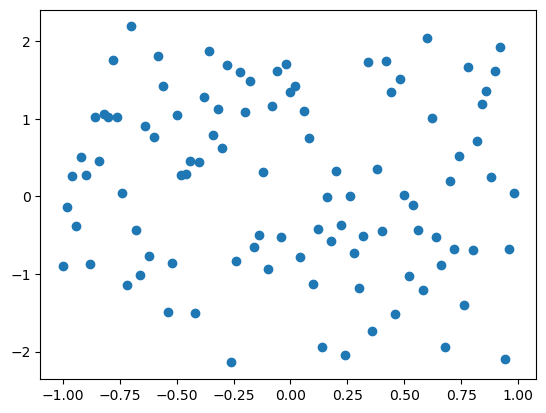

In [36]:
cfg = defaults()

def load_toy_data(config,
                 N: int, 
                 x_start: float, 
                 x_end: float, 
                 p_start: float, 
                 p_end: float, 
                 batch_size: int, 
                 shuffle: bool) -> Dict:
    toy_dataset = ToyDataset(N=N, x_start=x_start, x_end=x_end, p_start=p_start, p_end=p_end)
    toy_dataset.plot_log_odds()
    toy_dataloader = DataLoader(toy_dataset, batch_size=batch_size, shuffle=shuffle)
    return toy_dataset, toy_dataloader

toy_dataset, toy_dataloader = load_toy_data(cfg, 100, -1, 1, 0.1, 0.9, 1024, True)

### Fiting the toy dataset
#### ExU vs. standard ReLU
Training prediction learned by a single hidden layer heural network with 1024 (a) standard ReLU, and (b) ReLU-n with ExU hidden units on the binary classfication toy dataset. 

In [48]:
config.num_basis_functions = 1024
config.hidden_sizes = [1024]
config.num_epoches = 10000
config.batch_size = 1024
print(config)


relu_nam = NAM(config=config, name="")
class NAM(nn.Module):
    def __init__(
        self, 
        config, 
        name: str, 
        in_features: int,
        num_units, 
        ) 

    
relu_nn = FeatureNN(config=config, name="F", in_features=1, num_units=config.num_basis_functions, feature_index=0)
exu_nn = FeatureNN(config=config, name="ExU", in_features=1, num_units=config.num_basis_functions, feature_index=0)

Config(device='cpu', seed=2023, num_epoches=10000, lr=0.01, batch_size=1024, hidden_sizes=[1024], activation='exu', dropout=0.1, feature_dropout=0.1, decay_rate=0.995, l2_regularization=0.1, output_regularization=0.1, num_basis_functions=1024)


#### training 
We use a batch size of 1024 with the Adam optimizer and a learning rate decay of 0.995 every epoch. The learning rate was tuned in $[1e-3, 1e-1)$ and we show the results with the best learning rate. (best = best accuracy?)

we use the loss $L(\theta)$ given by
$$
L(\theta) = \mathbb{E}
$$